# Project 5 - Least Square Monte Carlo Method


**Name:** Bowen Chen

**Section:** 1

**Date:** Feb 8, 2018 

In [18]:
# python set up
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd

## Question 1



Consider the following information on the stock of company XYZ: The current stock price
is \$40, and the volatility of the stock price is $\sigma$ = 20% per annum. Assume the prevailing
risk-free rate is r = 6% per annum. Use the following method to price the specified option:



Start with simualtion 100,000 paths for stock prices of XYZ

In [19]:
def StockPrices(S0, r, sd, T, paths, steps):
    
    dt = T/steps
    
    # Generate stochastic process and its antithetic paths
    Z = np.random.normal(0, 1, paths//2 * steps).reshape((paths//2, steps))
    Z_inv = -Z
    
    dWt = math.sqrt(dt) * Z
    dWt_inv = math.sqrt(dt) * Z_inv
    
    # bind the normal and antithetic Wt
    dWt = np.concatenate((dWt, dWt_inv), axis=0)
    
    St = np.zeros((paths, steps + 1))
    St[:, 0] = S0
    
    for i in range (1, steps + 1):
        St[:, i] = St[:, i - 1]*np.exp((r - 1/2*np.power(sd, 2))*dt + sd*dWt[:, i - 1])
    
    return St[:, 1:]

Build function that calculates the specified number of terms in the Laguerre polynomials, return the result in an X matrix

In [20]:
def laguerre_polynomials(S, k):
    
    #  the first k terms of Laguerre Polynomials (k<=4)
    x1 = np.exp(-S/2)
    x2 = np.exp(-S/2) * (1 - S)
    x3 = np.exp(-S/2) * (1 - 2*S + S**2/2)
    x4 = np.exp(-S/2) * (1 - 3*S + 3* S**2/2 - S**3/6)
    
    X  = [np.stack([x1, x2], axis = 1),
          np.stack([x1, x2, x3], axis = 1),
          np.stack([x1, x2, x3, x4], axis = 1)]
    
    return X[k-2]

Build function that calculates the specified number of terms in the Hermite polynomials, return the result in an X matrix

In [21]:
def hermite_polynomials(S, k):
    
    #  the first k terms of Laguerre Polynomials (k<=4)
    x1 = np.ones(S.shape)
    x2 = 2*S
    x3 = 4*S**2 - 2
    x4 = 8*S**3 - 12
    
    X  = [np.stack([x1, x2], axis = 1),
          np.stack([x1, x2, x3], axis = 1),
          np.stack([x1, x2, x3, x4], axis = 1)]
    
    return X[k-2]

Build function that calculates the specified number of terms in the monomials, return the result in an X matrix

In [22]:
def monomials(S, k):
    
    #  the first k terms of Laguerre Polynomials (k<=4)
    x1 = np.ones(S.shape)
    x2 = S
    x3 = S**2
    x4 = S**3 
    
    X  = [np.stack([x1, x2], axis = 1),
          np.stack([x1, x2, x3], axis = 1),
          np.stack([x1, x2, x3, x4], axis = 1)]
    
    return X[k-2]

Build function that valuates the American put option with given polynomials for given k. 

In [117]:
def LSMC(S0, K, r, sd, T, paths, k, polynomials):
    
    mult = 50
    steps = int(mult*T)
    St = StockPrices(S0, r, sd, T, paths, steps)/K
    dt = T/steps

    # initialize cash flow matrix
    cashFlow = np.zeros((paths, steps))
    cashFlow[:,steps - 1] = np.maximum(1 - St[:,steps - 1], 0)

    # initialize continuation value matrix
    cont_value = cashFlow

    # initialize stopping time matrix
    decision = np.zeros((paths, steps))
    decision[:, steps - 1] = 1

    # build discount factor
    discountFactor = np.tile(np.exp(-r*dt* np.arange(1, 
                                    steps + 1, 1)), paths).reshape((paths, steps))

    for i in reversed(range(steps - 1)):

        # Find in the money paths
        in_the_money_n = np.where(1 - St[:, i] > 0)[0]
        out_of_money_n = np.asarray(list(set(np.arange(paths)) 
                                            - set(in_the_money_n)))

        #  Use the first k terms of Laguerre Polynomials
        if polynomials == 'laguerre':
            X = laguerre_polynomials(St[in_the_money_n, i], k)
            
        elif polynomials == 'hermite':
            X = hermite_polynomials(St[in_the_money_n, i], k)
            
        elif polynomials == 'monomials':
            X = monomials(St[in_the_money_n, i], k)
        else:
            print ('Error: Please Choose the Right Polynomials to Estimate')
            
            
        Y = cashFlow[in_the_money_n, i + 1]/np.exp(r*dt)

        # Find Least Square Beta
        A = np.dot(X.T, X)
        b = np.dot(X.T, Y)
        Beta = np.dot(np.linalg.pinv(A), b)

        # find continuation value
        cont_value[in_the_money_n,i] =  np.dot(X, Beta)
        try:
            cont_value[out_of_money_n,i] =  cont_value[out_of_money_n, i + 1]/np.exp(r*dt)
        except:
            pass

        # update decision rule
        decision[:, i] = np.where(np.maximum(1 - St[:, i], 0)  - cont_value[:,i] >= 0, 1, 0)
        
        # update cash flow matrix
        cashFlow[:, i] =  np.maximum(1 - St[:, i], cont_value[:,i])
    
    # Find the first occurence of 1, indicating the early exercise date
    first_exercise = np.argmax(decision, axis = 1) 
    decision = np.zeros((len(first_exercise), steps))
    decision[np.arange(len(first_exercise)), first_exercise] = 1
    
    option_value = np.mean(np.sum(decision*discountFactor*cashFlow*K, axis = 1))
    
    return option_value

Initialize parameters

In [118]:
sd = 0.25
r = 0.04
paths = 100000 
K = 40
np.random.seed(7)

S0 = [36, 40, 44]
T = [0.5, 1, 2]
k = [2, 3, 4]

**(a)** Use the LSMC method with 100,000 paths simulations (50,000 plus 50,000 antithetic)
to price an American put option with strike price of X = \$40, maturity of 0.5-years, 1-
year, 2-years, and current stock prices of \$36, \$40, \$44. Use the first k of the
Laguerre polynomials for k = 2, 3, 4.

**Solution:**

Find the option value with varying number of terms in the sequence (k) and varying intial prices ($S_0$)

In [119]:
American_put_values_laguerre = {}
for s in S0:
    for t in T:
        for i in k:
            
            American_put_values_laguerre[(s, t, i)] = round(LSMC(s, K, r, sd, t, paths, i, 'laguerre'), 5)

In [120]:
columns = ['Initial Price (S0)', 'Maturity T', 'Num terms (k)', 'Value Laguerre ($)']
American_put_laguerre = pd.concat([pd.DataFrame(list(American_put_values_laguerre.keys())), 
            pd.DataFrame(list(American_put_values_laguerre.values()))], axis  = 1)
American_put_laguerre.columns = columns

**(b)** Use the LSMC method with 100,000 paths simulations (50,000 plus 50,000 antithetic)
to price an American put option with strike price of X = \$40, maturity of 0.5-years, 1-
year, 2-years, and current stock prices of \$36, \$40, \$44. Use the first k of the
Hermite polynomials for k = 2, 3, 4.

**Solution:**

Use the same technique, construct the function that calculates the American Option prices using Hermite Polynomials

In [121]:
American_put_values_hermite = {}
for s in S0:
    for t in T:
        for i in k:
            American_put_values_hermite[(s, t, i)] = round(LSMC(s, K, r, sd, t, paths, i, 'hermite'), 5)

In [122]:
columns = ['Initial Price (S0)', 'Maturity T', 'Num terms (k)', 'Value Hermite ($)']
American_put_hermite = pd.concat([pd.DataFrame(list(American_put_values_hermite.keys())), 
            pd.DataFrame(list(American_put_values_hermite.values()))], axis  = 1)
American_put_hermite.columns = columns

**(c)** Use the LSMC method with 100,000 paths simulations (50,000 plus 50,000 antithetic)
to price an American put option with strike price of X = \$40, maturity of 0.5-years, 1-
year, 2-years, and current stock prices of \$36, \$40, \$44.  Use the first k of the monomials for k = 2, 3, 4.

**Solution:**

Use the same technique, construct the function that calculates the American Option prices using simple monomials

In [123]:
American_put_values_monomials = {}
for s in S0:
    for t in T:
        for i in k:
            American_put_values_monomials[(s, t, i)] = round(LSMC(s, K, r, sd, t, paths, i, 'monomials'), 5)
            

In [124]:
columns = ['Initial Price (S0)', 'Maturity T', 'Num terms (k)', 'Value Monomial ($)']
American_put_monomials = pd.concat([pd.DataFrame(list(American_put_values_monomials.keys())), 
            pd.DataFrame(list(American_put_values_monomials.values()))], axis  = 1)
American_put_monomials.columns = columns

In [125]:
AM_put = pd.concat([American_put_laguerre, American_put_hermite['Value Hermite ($)'], 
           American_put_monomials['Value Monomial ($)']], axis= 1)
AM_put

,Initial Price (S0),Maturity T,Num terms (k),Value Laguerre ($),Value Hermite ($),Value Monomial ($)
0,36,0.5,2,4.69575,4.67656,4.67937
1,36,0.5,3,4.70943,4.69646,4.70196
2,36,0.5,4,4.70752,4.72087,4.71242
3,36,1.0,2,5.31094,5.25247,5.26571
4,36,1.0,3,5.33153,5.32743,5.32780
5,36,1.0,4,5.33704,5.34687,5.31938
6,36,2.0,2,6.11958,5.99286,5.99480
7,36,2.0,3,6.14256,6.13569,6.15033
8,36,2.0,4,6.15156,6.15770,6.15348
9,40,0.5,2,2.46942,2.46034,2.44179


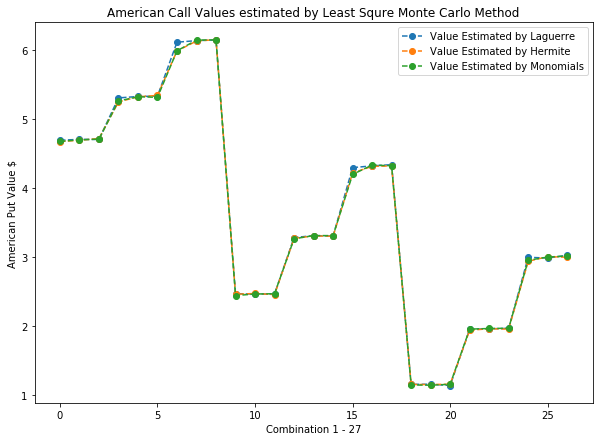

In [126]:
plt.figure(figsize=(10, 7))
plt.plot(AM_put['Value Laguerre ($)'],  linestyle='--', 
         marker='o', label = 'Value Estimated by Laguerre')

plt.plot(AM_put['Value Hermite ($)'],   linestyle='--',
         marker='o', label = 'Value Estimated by Hermite')

plt.plot(AM_put['Value Monomial ($)'],  linestyle='--',  
         marker='o',label = 'Value Estimated by Monomials')

plt.legend()
plt.xlabel('Combination 1 - 27')
plt.ylabel('American Put Value $')
plt.title('American Call Values estimated by Least Squre Monte Carlo Method')
plt.show()

**(d)** Compare the result and comment

On the graph above, from left to right represents different combinations of strike prices, time to maturity and number of terms used in the regression. Theoritically, the number of terms used in the regression should not yield big difference in prices calculated. From the data table and the graph above, the property is evident as varying the number of terms used in the OLS regression does not change the price of option very much. When the time to maturity is 2, and the number of terms used in the regression is also 2, the Laguerre regression yields a slightly higher price than Hermite polynomials and monomials. For performance purposes, the number of steps multiplier is chosen to be 50

## Question 2



Forward-start options are path dependent options that have strike prices to be determined at
a future date. For example, a forward start put option payoff at maturity is
$$max(S_t - S_T, 0)$$
where the strike price of the put option is $S_t$
. Here $0 \leq t \leq T$.

**(a)** Estimate the value of the forward-start European put option on a stock with these
characteristics: $S_0$ = $65, K = $60, $\sigma$ = 20% per annum, risk-free rate is r = 6% per
annum, t = 0.2 and T = 1.

**Solution:**

The stock price generation could be reused in this question, the strike price could be determined for each path useing the stock prices. Since the European option has no right of early exercising, there is no need to use Least Square Monte Carlo Method

Initialize Parameters

In [33]:
sd = 0.2
r = 0.06
paths = 100000
K = 60
S0 = 65
T = 1
t = 0.2
np.random.seed(7)

Build the function that values forward start European option

In [112]:
def forwardStart_European(S0, t, r, sd, T, paths):
    
    mult = 252
    steps = int(mult*T)
    St = StockPrices(S0, r, sd, T, paths, steps)
    dt = T/steps 
    
    # Determine Strike Pices of each paths
    K = St[:, int(mult* t)]
    
    # Find the option value for each paths at time T
    cashFlow = np.maximum(K - St[:,steps - 1], 0)
    option_value = np.mean(cashFlow)*np.exp(-r*t)
    
    return option_value

In [113]:
print("The value of forward start European Option: $", round(forwardStart_European(S0, t, r, sd, T, paths), 5))

The value of forward start European Option: $ 3.30624


**(b)** Estimate the value of the forward-start American put option on a stock with these
characteristics: $S_0$ = $65, K = $60, $\sigma$ = 20% per annum, risk-free rate is r = 6% per
annum, t = 0.2 and T = 1.

**Solution:**

In [114]:
def forwardStart_put_LSMC(S0, t, r, sd, T, paths):
    
    mult = 252
    steps = int(mult*T)
    St = StockPrices(S0, r, sd, T, paths, steps)
    dt = T/steps

    # Determine Strike Pices of each paths
    K = St[:, int(mult* t)]
    
    # initialize cash flow matrix
    cashFlow = np.zeros((paths, steps))
    cashFlow[:,steps - 1] = np.maximum(K - St[:,steps - 1], 0)/K

    # initialize continuation value matrix
    cont_value = cashFlow

    # initialize stopping time matrix
    decision = np.zeros((paths, steps))
    decision[:, steps - 1] = 1

    # build discount factor
    discountFactor = np.tile(np.exp(-r*dt* np.arange(1, 
                                    steps + 1, 1)), paths).reshape((paths, steps))
    
    for i in reversed(range(int(t*steps), (steps - 1))):

        # Find in the money paths
        in_the_money_n = np.where(K - St[:, i] > 0)[0]
        out_of_money_n = np.asarray(list(set(np.arange(paths)) 
                                            - set(in_the_money_n)))

        X = monomials(np.divide(St[in_the_money_n, i],K[in_the_money_n]), 4)            
        Y = cashFlow[in_the_money_n, i + 1]/np.exp(r*dt)

        # Find Least Square Beta
        A = np.dot(X.T, X)
        b = np.dot(X.T, Y)
        Beta = np.dot(np.linalg.pinv(A), b)

        # find continuation value
        cont_value[in_the_money_n,i] =  np.dot(X, Beta)
        try:
            cont_value[out_of_money_n,i] =  cont_value[out_of_money_n, i + 1]/np.exp(r*dt)
        except:
            pass

        # update decision rule
        decision[:, i] = np.where(np.maximum(K - St[:, i], 0)  - cont_value[:,i] >= 0, 1, 0)
        
        # update cash flow matrix
        cashFlow[:, i] =  np.maximum((K - St[:, i])/K, cont_value[:,i])
    
    # Find the first occurence of 1, indicating the early exercise date
    first_exercise = np.argmax(decision, axis = 1) 
    decision = np.zeros((len(first_exercise), steps))
    decision[np.arange(len(first_exercise)), first_exercise] = 1
    
    option_value = np.mean(np.sum(decision*discountFactor*cashFlow* np.tile(K.reshape((paths, 1)), steps), axis = 1))
    
    return option_value

In [115]:
sd = 0.2
r = 0.06
paths = 100000
K = 60
S0 = 65
T = 1
t = 0.2
np.random.seed(7)

In [116]:
print("The value of forward start American Put Option: $", round(forwardStart_put_LSMC(S0, t, r, sd, T, paths), 5))

The value of forward start American Put Option: $ 3.48643
